In [23]:
import os

def count_images_with_labels(image_folder, label_folder, image_ext=".jpg", label_ext=".txt"):
    # List all image and label file names
    image_files = [f for f in os.listdir(image_folder) if f.endswith(image_ext)]
    label_files = [f for f in os.listdir(label_folder) if f.endswith(label_ext)]
    
    # Extract base names (without extensions) for comparison
    image_basenames = {os.path.splitext(f)[0] for f in image_files}
    label_basenames = {os.path.splitext(f)[0] for f in label_files}
    
    # Find intersection of image and label base names
    matched_files = image_basenames.intersection(label_basenames)
    
    # Print results
    print(f"Total images: {len(image_files)}")
    print(f"Total labels: {len(label_files)}")
    print(f"Images with labels: {len(matched_files)}")
    print(f"Images without labels: {len(image_files) - len(matched_files)}")
    
    return matched_files

# Specify folders
image_folder = '/Users/goutham/Updated/Final_dataset/56k_train_images'  # Replace with your training spectrogram images path
label_folder = '/Users/goutham/Updated/Final_dataset/56k_train_labels' # Replace with the path to your label folder

# Call the function
matched_files = count_images_with_labels(image_folder, label_folder)


Total images: 56000
Total labels: 88893
Images with labels: 56000
Images without labels: 0


In [24]:
import os

def create_missing_labels(image_folder, label_folder, image_ext=".jpg", label_ext=".txt"):
    # Get all image and label file names
    image_files = [f for f in os.listdir(image_folder) if f.endswith(image_ext)]
    label_files = [f for f in os.listdir(label_folder) if f.endswith(label_ext)]
    
    # Extract base names (without extensions) for comparison
    image_basenames = {os.path.splitext(f)[0] for f in image_files}
    label_basenames = {os.path.splitext(f)[0] for f in label_files}
    
    # Find images without labels
    unmatched_images = image_basenames - label_basenames
    
    for base_name in unmatched_images:
        # Extract SINR value from the file name
        parts = base_name.split('_')
        sinr_part = next((part for part in parts if part.startswith('SINR')), None)
        
        if sinr_part:
            sinr_value = int(sinr_part[4:])  # Extract numeric part after 'SINR'
            label_value = 1 if sinr_value != 100 else 0
            
            # Create the corresponding text file in the label folder
            label_path = os.path.join(label_folder, f"{base_name}{label_ext}")
            with open(label_path, 'w') as label_file:
                label_file.write(str(label_value))
    
    print(f"Created {len(unmatched_images)} label files for unmatched images.")

image_folder = '/Users/goutham/Updated/Final_dataset/56k_train_images'  # Replace with your training spectrogram images path
label_folder = '/Users/goutham/Updated/Final_dataset/56k_train_labels' # Replace with the path to your label folder


# Call the function
create_missing_labels(image_folder, label_folder)

Created 0 label files for unmatched images.


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from datetime import datetime
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [26]:
# Define a model with VGG16 as base for transfer learning
def create_model(input_shape):
    # Load VGG16 model without the fully connected layers (include_top=False)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the layers of VGG16
    base_model.trainable = False

    for layer in base_model.layers[-3:]:
        layer.trainable = True

    
    # Create a new sequential model
    model = Sequential()
    
    # Add the VGG16 base model (without the top layers)
    model.add(base_model)
    
    # Add a flatten layer to the output from VGG16
    model.add(Flatten())
    
    # Add a custom dense layer for classification
    model.add(Dense(64, activation='gelu'))  # GELU activation
    
    # Dropout to prevent overfitting
    model.add(Dropout(0.6))
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    return model


In [27]:
# Set the input shape (height, width, channels)
input_shape = (64, 64, 3)  # For 64x64 RGB images

# Create the model
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,845,889 (56.63 MB)

 Trainable params: 4,850,817 (18.50 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [28]:
#Load the data
image_folder = '/Users/goutham/Updated/Final_dataset/56k_train_images'  # Replace with the path to your images
txt_folder = '/Users/goutham/Updated/Final_dataset/56k_train_labels'  # Replace with the path to your txt labels


In [29]:
# Prepare lists for image paths and labels
image_paths = []
labels = []

# Load image paths and labels from the txt files
for txt_file in os.listdir(txt_folder):
    if txt_file.endswith('.txt'):
        with open(os.path.join(txt_folder, txt_file), 'r') as file:
            label = int(file.read().strip())
            image_name = os.path.splitext(txt_file)[0] + '.jpg'  # Assuming images are in .jpg format
            image_path = os.path.join(image_folder, image_name)
            if os.path.exists(image_path):
                image_paths.append(image_path)
                labels.append(label)
print(len(image_path),len(labels))

# Prepare training data
training_image_paths, training_labels = image_paths, labels

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

89 56000


In [30]:
# Helper function to generate batches from paths and labels
def data_generator(image_paths, labels, batch_size, target_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            images = []
            for path in batch_paths:
                image = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
                image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                images.append(image)
            yield np.array(images), np.array(batch_labels)

# Set batch size and target size
batch_size = 32
target_size = (64, 64)

# Create generator for training
generator_train = data_generator(training_image_paths, training_labels, batch_size, target_size)

In [31]:
generator_train

<generator object data_generator at 0x175a23ba0>

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from datetime import datetime



In [33]:
# Define log directory for TensorBoard
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


In [34]:

# Initial learning rate, decay rate, and decay steps for exponential decay
initial_learning_rate = 0.001
decay_rate = 0.96
decay_steps = 1000


In [35]:

# Set up the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # Decays at discrete intervals
)


In [36]:

# Set up callbacks
callbacks = [
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    EarlyStopping(monitor='loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.00001),
    ModelCheckpoint('decay_new_30epoch_binary_classification_VGG16.keras', monitor='loss', save_best_only=True)
]


In [37]:

# Compile model with the exponential decay learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',  # Assuming binary classification task
    metrics=['accuracy']
)


In [39]:
# Train the model in mini-batches to accommodate CPU training
model.fit(
    generator_train,
    steps_per_epoch=len(training_image_paths) // batch_size,
    epochs=30,
    #use_multiprocessing=False,  # Disable multiprocessing for CPU-only training
    #workers=1  # Use a single worker for CPU efficiency
    callbacks = callbacks
)

# Save the trained model
model.save('decay_new_30epoch_binary_classification_VGG16.keras')

Epoch 1/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 740s 423ms/step - accuracy: 0.8631 - loss: 0.3732 - learning_rate: 9.2160e-04
Epoch 2/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 837s 478ms/step - accuracy: 0.8700 - loss: 0.3451 - learning_rate: 8.4935e-04
Epoch 3/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 890s 509ms/step - accuracy: 0.8716 - loss: 0.3366 - learning_rate: 7.8276e-04
Epoch 4/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 720s 412ms/step - accuracy: 0.8731 - loss: 0.3299 - learning_rate: 7.2139e-04
Epoch 5/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 765s 437ms/step - accuracy: 0.8743 - loss: 0.3221 - learning_rate: 6.9253e-04
Epoch 6/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 750s 429ms/step - accuracy: 0.8745 - loss: 0.3189 - learning_rate: 6.3824e-04
Epoch 7/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 743s 425ms/step - accuracy: 0.8755 - loss: 0.3142 - learning_rate: 5.8820e-04
Epoch 8/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 715s 408ms/step - accuracy: 0.8771 - loss: 0.3088 - learning_rate: 5.4209e-04
Epoch 9/30
1750/1750 ━━━━━━━━━━━━━━━━━━━

In [8]:
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [9]:
# Load the saved model
model_path = 'decay_new_30epoch_binary_classification_VGG16.keras'
model = tf.keras.models.load_model(model_path)


In [10]:
# Test data paths
test_image_folder = '//Users/goutham/17k_test_images'  # Test images path
test_txt_folder = '/Users/goutham/17k_test_labels'    # Test labels path


In [11]:
# Prepare lists for test image paths and labels
test_image_paths = []
test_labels = []


In [12]:
# Load test image paths and labels
for txt_file in os.listdir(test_txt_folder):
    if txt_file.endswith('.txt'):
        with open(os.path.join(test_txt_folder, txt_file), 'r') as file:
            label = int(file.read().strip())
            image_name = os.path.splitext(txt_file)[0] + '.jpg'  # Assuming test images are in .jpg format
            image_path = os.path.join(test_image_folder, image_name)
            if os.path.exists(image_path):
                test_image_paths.append(image_path)
                test_labels.append(label)


In [13]:
# Check if there are any test images
if len(test_image_paths) == 0:
    print("No test images found. Please check the test_image_folder path and ensure files are available.")
else:
    # Prepare test images array
    X_test = []
    for path in test_image_paths:
        image = tf.keras.preprocessing.image.load_img(path, target_size=(64, 64))
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        X_test.append(image)
    X_test = np.array(X_test)
    y_test = np.array(test_labels)

    # Check the shape of X_test
    print(f'Shape of X_test: {X_test.shape}')  # Should be (num_samples, height, width, channels)

    # Predict only if X_test has data
    if X_test.shape[0] > 0:
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        #roc_auc = roc_auc_score(y_test, y_pred_prob)

        # Print metrics
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        #print(f'ROC AUC Score: {roc_auc:.4f}')
    else:
        print("X_test is empty, no predictions can be made.")

Shape of X_test: (17000, 64, 64, 3)
532/532 ━━━━━━━━━━━━━━━━━━━━ 251s 471ms/step
Accuracy: 0.9359
Precision: 0.9560
Recall: 0.9769
F1 Score: 0.9663


532/532 ━━━━━━━━━━━━━━━━━━━━ 254s 477ms/step


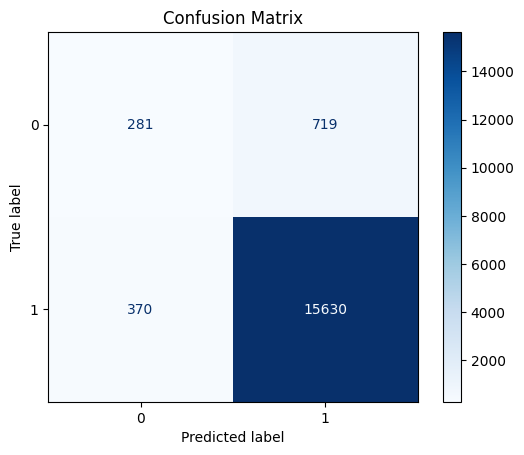

Accuracy: 0.9359
Precision: 0.9560
Recall: 0.9769
F1 Score: 0.9663


In [14]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Load your .keras model
model = load_model('decay_new_30epoch_binary_classification_VGG16.keras')

# Predict on the test set (for binary classification)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Threshold at 0.5 to get binary predictions (0 or 1)

# Ensure that y_test is in the correct format (single dimension with 0 and 1 labels)
y_true = y_test if y_test.ndim == 1 else np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate and print additional performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
#roc_auc = roc_auc_score(y_true, y_pred_prob)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
#print(f'ROC AUC Score: {roc_auc:.4f}')